In [151]:
import numpy as np
import scipy as sci
import math
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
import matplotlib.pyplot as plt 
import pandas as pd

**Actividad 1**

En esta actividad la idea principal es medir el espectro característico de rayos X del cobre (Cu). Para esto, se utilizó el montaje  que se ve en la figura. Tomamos datos como se indicó en la guía. Acá primero vamos a definir las funciones de ajuste que usaremos en el análisis.


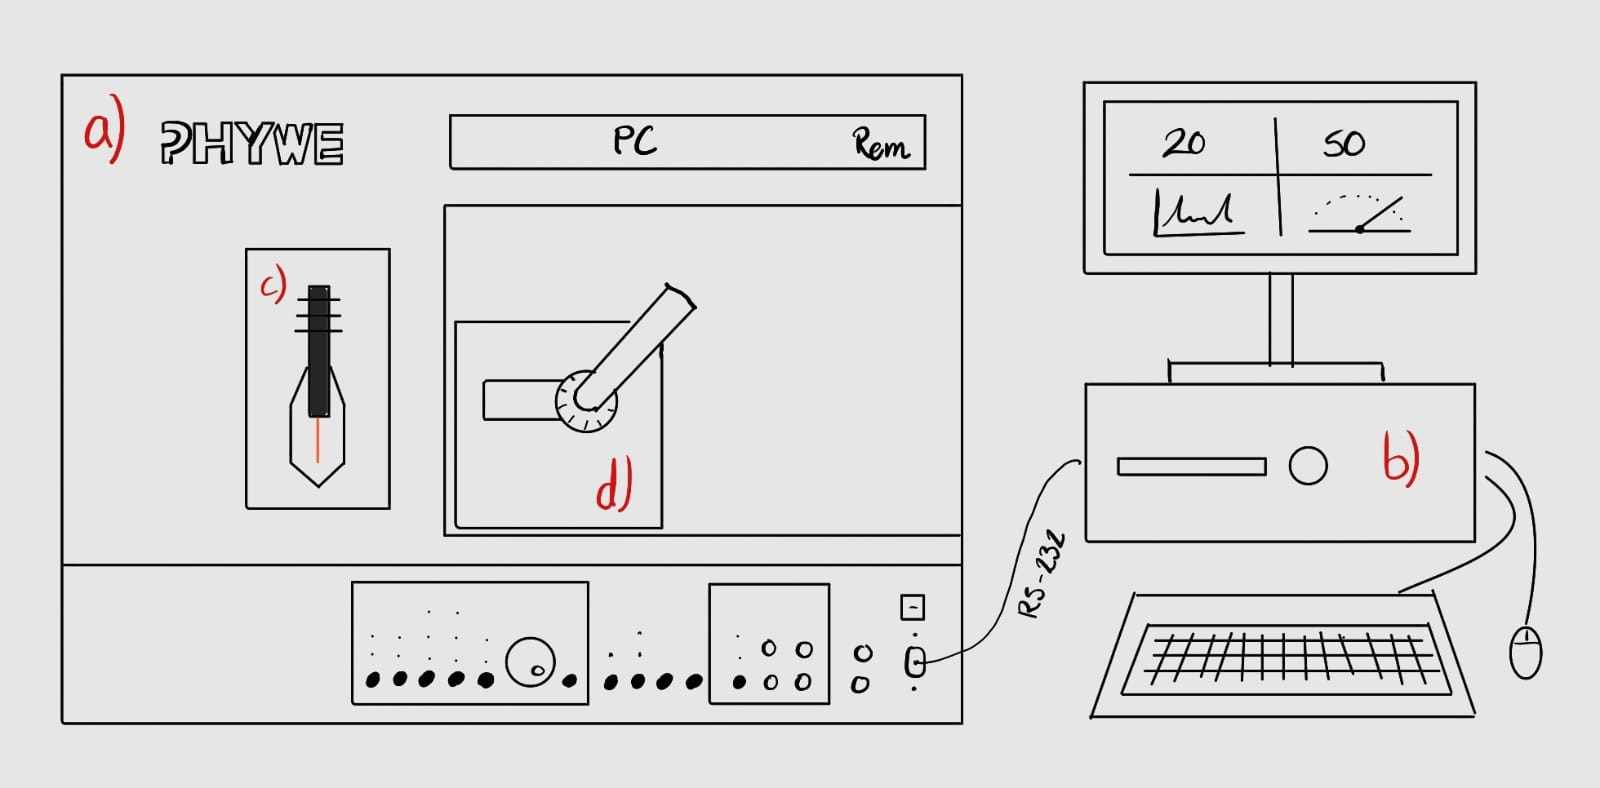

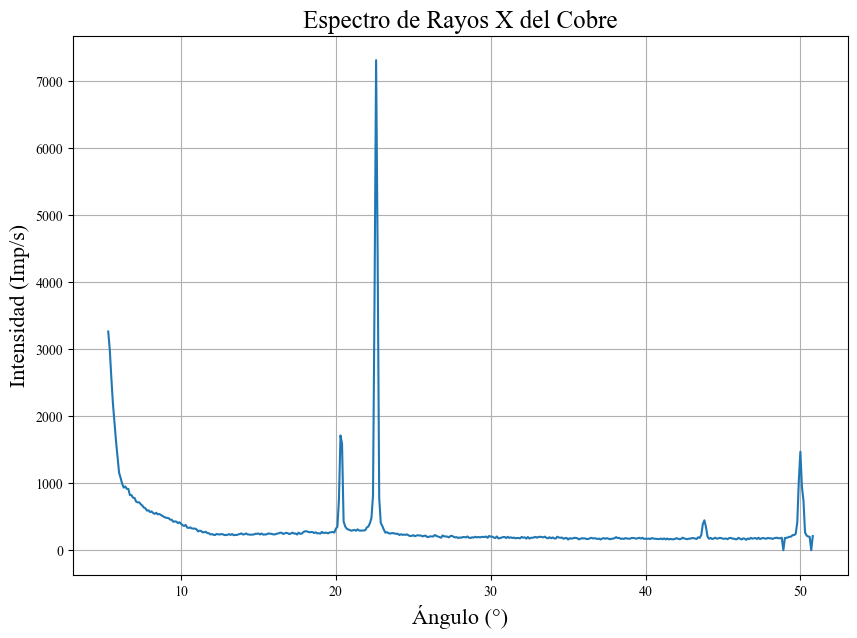

In [152]:
def lorentz(x, A, x0, gamma):
    return (A / np.pi) * (gamma / ((x - x0)**2 + gamma**2))

def double_lorentz(x, A1, x01, gamma1, A2, x02, gamma2):
    return lorentz(x, A1, x01, gamma1) + lorentz(x, A2, x02, gamma2)

def linear(x, a, b):
    return a*x + b

def voigt(x, A, x0, sigma, gamma):
    return A * voigt_profile(x - x0, sigma, gamma)

def double_voigt(x, A1, x01, sigma1, gamma1, A2, x02, sigma2, gamma2):
    return voigt(x, A1, x01, sigma1, gamma1) + voigt(x, A2, x02, sigma2, gamma2)

def bragg (d,theta,n):
    return 2/n* (d*np.sin(np.deg2rad(theta)))

def inc_bragg (d,theta,itheta,n):
    theta_=np.deg2rad(theta)
    itheta_=np.deg2rad(itheta)
    return 2/n* (d*np.cos(theta_)*itheta_)
def Error(valor_principal, incertidumbre):
    # Determinar cuántas cifras significativas tiene la incertidumbre
    if incertidumbre == 0:
        return valor_principal, incertidumbre  # Evita la división por cero
    
    cifras_significativas = -int(math.floor(math.log10(incertidumbre)))
    
    # Redondear el valor principal y la incertidumbre a esas cifras significativas
    valor_redondeado = round(valor_principal, cifras_significativas)
    incertidumbre_redondeada = round(incertidumbre, cifras_significativas)
    
    return valor_redondeado, incertidumbre_redondeada

data = pd.read_excel("Rayos X.xlsx",sheet_name="Hoja1")
angulos=(data['Ángulo'].to_numpy())+2.3
intensidad=data['Intensidad'].to_numpy()

angulos

plt.rc('font', family='Times New Roman') 
plt.figure(figsize = (10, 7))
plt.plot(angulos,intensidad)
plt.ylabel("Intensidad (Imp/s)", fontsize=16)
plt.title("Espectro de Rayos X del Cobre", fontsize=18)
plt.xlabel("Ángulo (°)",fontsize=16)
plt.grid(True)


Esta es una gráfica ilustrativa. En realidad, debemos usar la ley de Bragg
\begin{equation*}
n \lambda = 2d \text{sin}\theta \quad,\quad n\in \mathbb{N}
\end{equation*}
 para pasar de ángulo a longitud de onda. En el código sumamos 2.3 grados a cada uno por que el valor teórico era 22.6° y a nosotros nos dió 20.3°, por eso el offset. Usamos la ley de Bragg con $n=1$ y $n=2$. Como nota, vemos como para ángulos pequeños la gráfica parece diverger. Esto es realmente porque en esta posición, el haz le da de lleno al cristal de LiF. Por lo tanto, estos ángulos no los vamos a tener en cuenta para los análisis que realicemos.

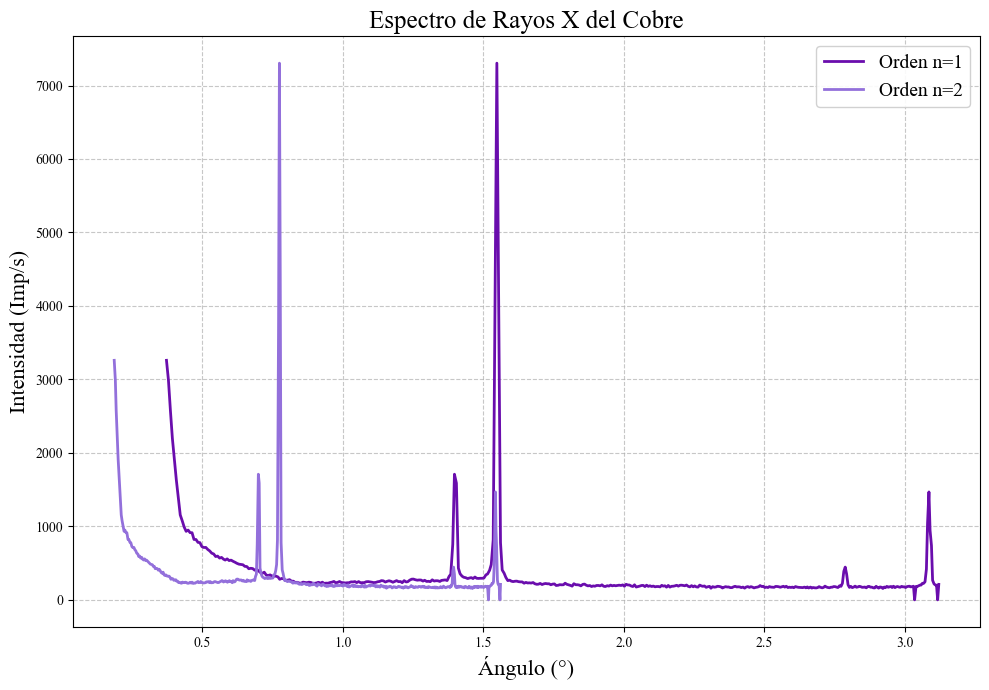

In [153]:
#Definimos antes las incertidumbres,como nuestro instrumento es analógico, su incertidumbre es su resolución.
inc_ang=0.1*np.ones(456)
inc_int=np.ones(456)
d=2.014 #Amstrongs
lambda1=bragg(d,angulos,1)
inc_lambda1=inc_bragg(d,angulos,inc_ang,1) 
lambda2=bragg(d,angulos,2)
inc_lambda2=inc_bragg(d,angulos,inc_ang,2) 
for i in range(len(lambda1)):
   lambda1[i]=Error(lambda1[i],inc_lambda1[i])[0]
   inc_lambda1[i]=Error(lambda1[i],inc_lambda1[i])[1]
for i in range(len(lambda2)):
   lambda2[i]=Error(lambda2[i],inc_lambda2[i])[0]
   inc_lambda2[i]=Error(lambda2[i],inc_lambda2[i])[1]


#Este pedacito de personalizar las gráficas lo hizo Deepseek. Yo no sabía como hacer que se viera así lindo, lo siento.

plt.rc('font', family='Times New Roman')
plt.figure(figsize=(10, 7))

# Curva 1: Azul oscuro (#1f77b4 es el azul estándar de matplotlib)
plt.plot(lambda1, intensidad, 
         color='#6A0DAD',  # Código HEX para azul oscuro
         linewidth=2, 
         label='Orden n=1')

# Curva 2: Azul claro (tono pastel)
plt.plot(lambda2, intensidad, 
         color='#9370DB',  # Código HEX para azul claro
         linewidth=2, 
         label='Orden n=2')

plt.ylabel("Intensidad (Imp/s)", fontsize=16)
plt.title("Espectro de Rayos X del Cobre", fontsize=18)
plt.xlabel("Ángulo (°)", fontsize=16)

# Leyenda con tamaño personalizado (14 puntos)
plt.legend(fontsize=14, 
           loc='best',  # Posición automática
           framealpha=0.9)  # Transparencia del fondo

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()  # Mejor ajuste de los elementos
plt.show()

Vemos como usar un segundo orden de difracción nos "corre" la gráfica para la izquierda. Ahora es momento de hallar las energías y longitudes de onda para las dos líneas características, es decir, $K_{\alpha}$ y $K_{\beta}$. Para esto, haremos dos ajustes, uno con una Loretziana y otro con el perfil de Voight.

C:\Users\PC\AppData\Local\Temp\ipykernel_28456\3524949876.py:11: RuntimeWarning: overflow encountered in multiply
  return A * voigt_profile(x - x0, sigma, gamma)


Text(0.5, 1.0, 'Residuales')

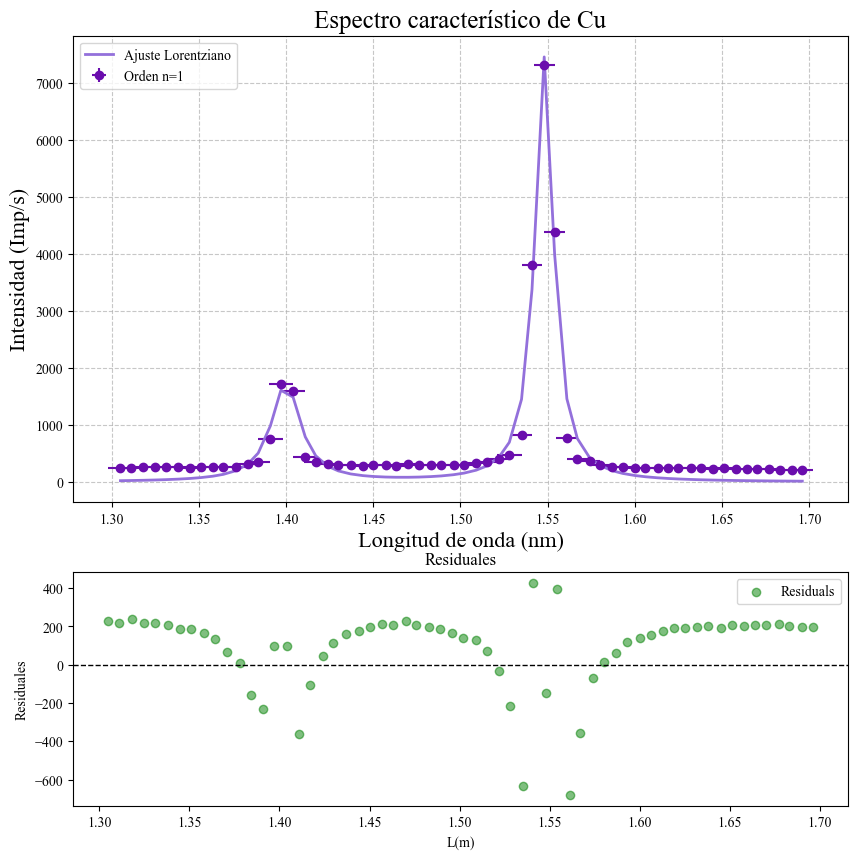

In [154]:
#Primero vamos a definir nuestras seeds para que esto converja como queremos
p0_lor=np.array([7304,1.54,0.02, 1750,1.39,0.02])
p0_voi=np.array([7304,1.54,0.01,0.02,1750,1.39,0.01,0.02]) 

#Ahora sí hacemos el fit y obtenemos nuestros parámetros con sus incertidumbres
param_lorentz,inc_lor=curve_fit(double_lorentz, lambda1, intensidad, p0=p0_lor, sigma=inc_int, absolute_sigma=True)
param_voight,inc_voight=curve_fit(double_voigt, lambda1, intensidad, p0=p0_voi,sigma=inc_int, absolute_sigma=True)

errors_lorentz = np.sqrt(np.diag(inc_lor))

A_1,x01, gamma1,A_2,x02, gamma2=param_lorentz
A1_err, x01_err, gamma1_err, A2_err, x02_err, gamma2_err = errors_lorentz

ajuste_lor1=double_lorentz(lambda1,A_1,x01,gamma1,A_2,x02,gamma2)
#Hacemos el cálculo de residuales

resid_lor1=(intensidad-ajuste_lor1)/inc_int

mask = (lambda1 >= 1.3) & (lambda1 <= 1.7)
lambda1_filtered = lambda1[mask]
intensidad_filtered = intensidad[mask]
ajuste_lor1_filtered = ajuste_lor1[mask]
inc_int_filtered=inc_int[mask]
inc_lambda1_filtered=inc_lambda1[mask]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1]})
ax1.errorbar(lambda1_filtered, intensidad_filtered, inc_int_filtered, inc_lambda1_filtered,color='#6A0DAD', fmt='o', label='Orden n=1')
ax1.plot(lambda1_filtered, ajuste_lor1_filtered, color='#9370DB', linewidth=2, label=f'Ajuste Lorentziano')
ax1.set_xlabel("Longitud de onda (nm)", fontsize=16)
ax1.set_ylabel("Intensidad (Imp/s)", fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')
ax1.set_title('Espectro característico de Cu', fontsize=18)

resid_lor1_filtered=resid_lor1[mask]
ax2.scatter(lambda1_filtered, resid_lor1_filtered, color='green', alpha=0.5, label='Residuals')
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_xlabel('L(m)')
ax2.set_ylabel('Residuales')
ax2.legend(loc='upper right')
ax2.set_title('Residuales')



C:\Users\PC\AppData\Local\Temp\ipykernel_28456\3524949876.py:11: RuntimeWarning: overflow encountered in multiply
  return A * voigt_profile(x - x0, sigma, gamma)


Text(0.5, 1.0, 'Residuales')

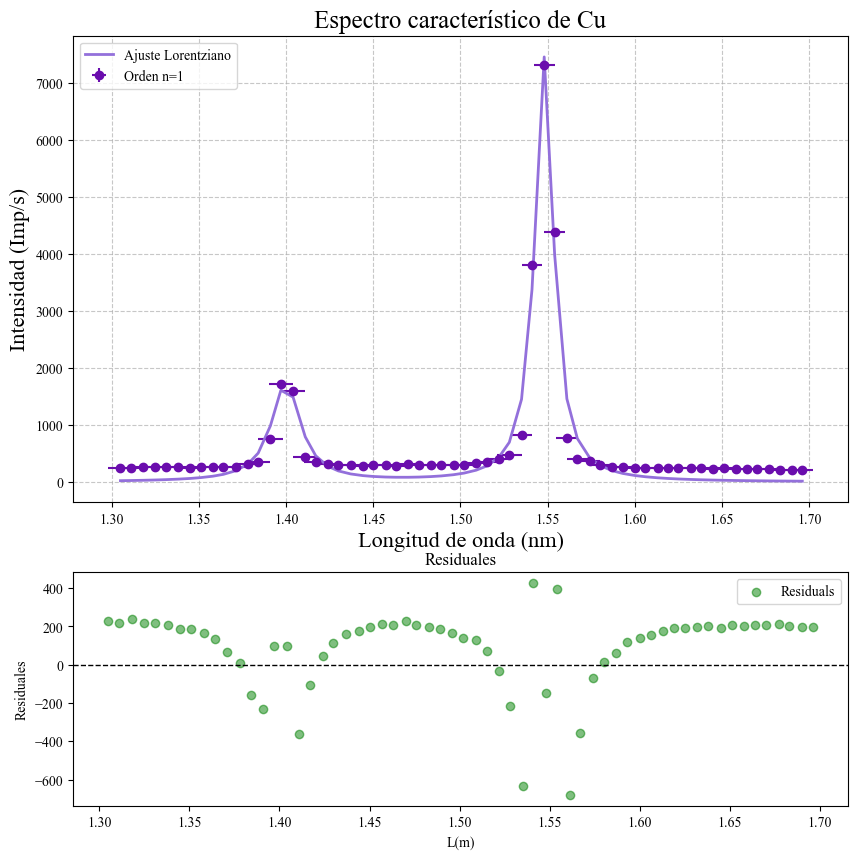

In [155]:
#Bueno,ahora es básicamente hacer lo mismo pero cambiar todos los números 1 por 2 xd.
#Primero vamos a definir nuestras seeds para que esto converja como queremos
p0_lor=np.array([7304,1.54,0.02, 1750,1.39,0.02])
p0_voi=np.array([7304,1.54,0.01,0.02,1750,1.39,0.01,0.02]) 

#Ahora sí hacemos el fit y obtenemos nuestros parámetros con sus incertidumbres
param_lorentz,inc_lor=curve_fit(double_lorentz, lambda1, intensidad, p0=p0_lor, sigma=inc_int, absolute_sigma=True)
param_voight,inc_voight=curve_fit(double_voigt, lambda1, intensidad, p0=p0_voi,sigma=inc_int, absolute_sigma=True)

errors_lorentz = np.sqrt(np.diag(inc_lor))

A_1,x01, gamma1,A_2,x02, gamma2=param_lorentz
A1_err, x01_err, gamma1_err, A2_err, x02_err, gamma2_err = errors_lorentz

ajuste_lor1=double_lorentz(lambda1,A_1,x01,gamma1,A_2,x02,gamma2)
#Hacemos el cálculo de residuales

resid_lor1=(intensidad-ajuste_lor1)/inc_int

mask = (lambda1 >= 1.3) & (lambda1 <= 1.7)
lambda1_filtered = lambda1[mask]
intensidad_filtered = intensidad[mask]
ajuste_lor1_filtered = ajuste_lor1[mask]
inc_int_filtered=inc_int[mask]
inc_lambda1_filtered=inc_lambda1[mask]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1]})
ax1.errorbar(lambda1_filtered, intensidad_filtered, inc_int_filtered, inc_lambda1_filtered,color='#6A0DAD', fmt='o', label='Orden n=1')
ax1.plot(lambda1_filtered, ajuste_lor1_filtered, color='#9370DB', linewidth=2, label=f'Ajuste Lorentziano')
ax1.set_xlabel("Longitud de onda (nm)", fontsize=16)
ax1.set_ylabel("Intensidad (Imp/s)", fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')
ax1.set_title('Espectro característico de Cu', fontsize=18)

resid_lor1_filtered=resid_lor1[mask]
ax2.scatter(lambda1_filtered, resid_lor1_filtered, color='green', alpha=0.5, label='Residuals')
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_xlabel('L(m)')
ax2.set_ylabel('Residuales')
ax2.legend(loc='upper right')
ax2.set_title('Residuales')

